In [1]:
!pip install --upgrade quantecon

In [2]:
import numpy as np
from quantecon import LQ
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class ChangLQ:
    """
    Class to solve LQ Chang model
    """
    def __init__(self, β, c, α=1, u0=1, u1=0.5, u2=3, T=1000, θ_n=200):
        # Record parameters
        self.α, self.u0, self.u1, self.u2 = α, u0, u1, u2
        self.β, self.c, self.T, self.θ_n = β, c, T, θ_n

        self.setup_LQ_matrices()
        self.solve_LQ_problem()
        self.compute_policy_functions()
        self.simulate_ramsey_plan()
        self.compute_θ_range()
        self.compute_value_and_policy()

    def setup_LQ_matrices(self):
        # LQ Matrices
        self.R = -np.array([[self.u0, -self.u1 * self.α / 2],
                            [-self.u1 * self.α / 2, 
                             -self.u2 * self.α**2 / 2]])
        self.Q = -np.array([[-self.c / 2]])
        self.A = np.array([[1, 0], [0, (1 + self.α) / self.α]])
        self.B = np.array([[0], [-1 / self.α]])

    def solve_LQ_problem(self):
        # Solve LQ Problem (Subproblem 1)
        lq = LQ(self.Q, self.R, self.A, self.B, beta=self.β)
        self.P, self.F, self.d = lq.stationary_values()

        # Compute g0, g1, and g2 (41.16)
        self.g0, self.g1, self.g2 = [-self.P[0, 0], 
                                     -2 * self.P[1, 0], -self.P[1, 1]]
        
        # Compute b0 and b1 (41.17)
        [[self.b0, self.b1]] = self.F

        # Compute d0 and d1 (41.18)
        self.cl_mat = (self.A - self.B @ self.F)  # Closed loop matrix
        [[self.d0, self.d1]] = self.cl_mat[1:]

        # Solve Subproblem 2
        self.θ_R = -self.P[0, 1] / self.P[1, 1]
        
        # Find the bliss level of θ
        self.θ_B = -self.u1 / (self.u2 * self.α)

    def compute_policy_functions(self):
        # Solve the Markov Perfect Equilibrium
        self.μ_MPE = -self.u1 / ((1 + self.α) / self.α * self.c 
                                 + self.α / (1 + self.α)
                                 * self.u2 + self.α**2 
                                 / (1 + self.α) * self.u2)
        self.θ_MPE = self.μ_MPE
        self.μ_CR = -self.α * self.u1 / (self.u2 * self.α**2 + self.c)
        self.θ_CR = self.μ_CR

        # Calculate value under MPE and CR economy
        self.J_θ = lambda θ_array: - np.array([1, θ_array]) \
                                   @ self.P @ np.array([1, θ_array]).T
        self.V_θ = lambda θ: (self.u0 + self.u1 * (-self.α * θ)
                              - self.u2 / 2 * (-self.α * θ)**2 
                              - self.c / 2 * θ**2) / (1 - self.β)
        
        self.J_MPE = self.V_θ(self.μ_MPE)
        self.J_CR = self.V_θ(self.μ_CR)

    def simulate_ramsey_plan(self):
        # Simulate Ramsey plan for large number of periods
        θ_series = np.vstack((np.ones((1, self.T)), np.zeros((1, self.T))))
        μ_series = np.zeros(self.T)
        J_series = np.zeros(self.T)
        θ_series[1, 0] = self.θ_R
        [μ_series[0]] = -self.F.dot(θ_series[:, 0])
        J_series[0] = self.J_θ(θ_series[1, 0])

        for i in range(1, self.T):
            θ_series[:, i] = self.cl_mat @ θ_series[:, i-1]
            [μ_series[i]] = -self.F @ θ_series[:, i]
            J_series[i] = self.J_θ(θ_series[1, i])

        self.J_series = J_series
        self.μ_series = μ_series
        self.θ_series = θ_series

    def compute_θ_range(self):
        # Find the range of θ in Ramsey plan
        θ_LB = min(min(self.θ_series[1, :]), self.θ_B)
        θ_UB = max(max(self.θ_series[1, :]), self.θ_MPE)
        θ_range = θ_UB - θ_LB
        self.θ_LB = θ_LB - 0.05 * θ_range
        self.θ_UB = θ_UB + 0.05 * θ_range
        self.θ_range = θ_range

    def compute_value_and_policy(self):        
        # Create the θ_space
        self.θ_space = np.linspace(self.θ_LB, self.θ_UB, 200)
        
        # Find value function and policy functions over range of θ
        self.J_space = np.array([self.J_θ(θ) for θ in self.θ_space])
        self.μ_space = -self.F @ np.vstack((np.ones(200), self.θ_space))
        x_prime = self.cl_mat @ np.vstack((np.ones(200), self.θ_space))
        self.θ_prime = x_prime[1, :]
        self.CR_space = np.array([self.V_θ(θ) for θ in self.θ_space])
        
        self.μ_space = self.μ_space[0, :]
        
        # Calculate J_range, J_LB, and J_UB
        self.J_range = np.ptp(self.J_space)
        self.J_LB = np.min(self.J_space) - 0.05 * self.J_range
        self.J_UB = np.max(self.J_space) + 0.05 * self.J_range

In [4]:
clq = ChangLQ(β=0.85, c=2)

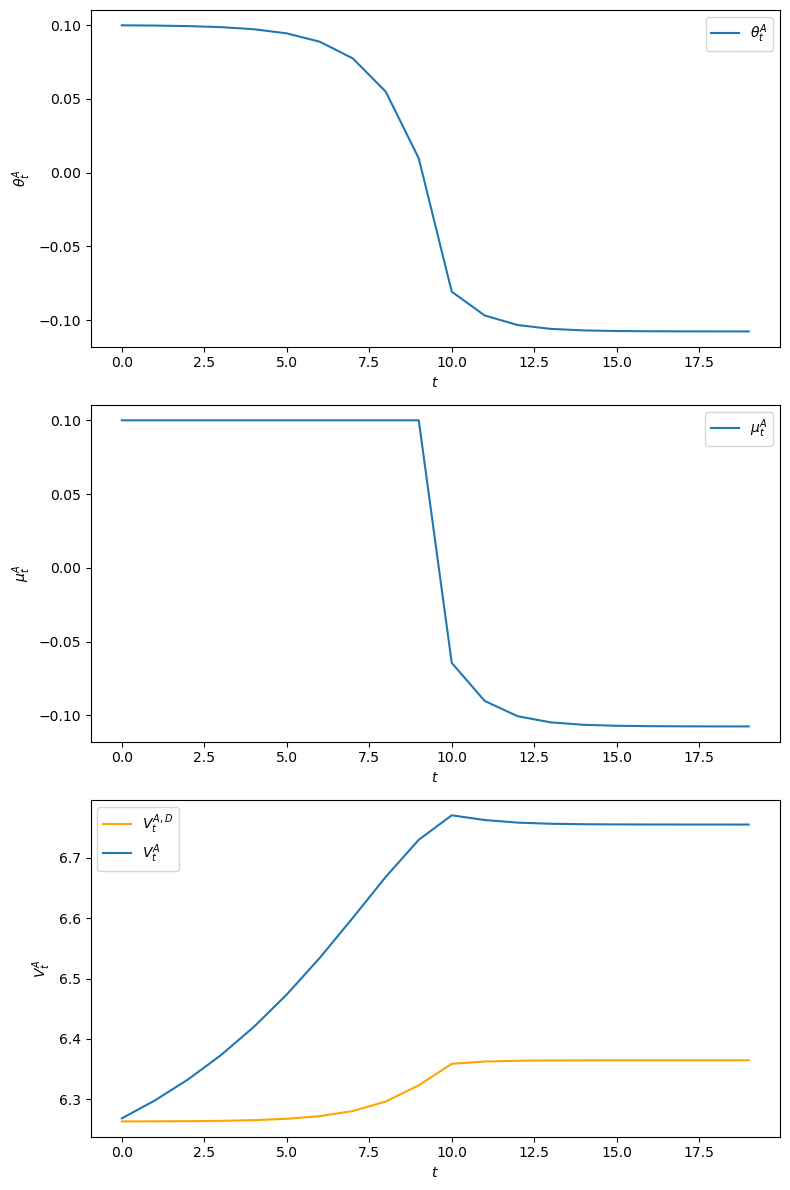

In [5]:
def abreu_plan(clq, T=1000, T_A=10, μ_bar=0.1, T_Plot=20):
    """
    Compute and plot the Abreu plan for the given ChangLQ instance.

    Here clq is an instance of ChangLQ.
    """
    # Append Ramsey μ series to stick μ series
    clq.μ_A = np.append(np.full(T_A, μ_bar), clq.μ_series[:-T_A])

    # Calculate implied stick θ series
    discount = (clq.α / (1 + clq.α)) ** np.arange(T)
    clq.θ_A = np.array([
        1 / (clq.α + 1) * np.sum(clq.μ_A[t:] * discount[:T - t])
        for t in range(T)
    ])

    # Calculate utility of stick plan
    U_A = clq.β ** np.arange(T) * (
        clq.u0 + clq.u1 * (-clq.θ_A) - clq.u2 / 2 
        * (-clq.θ_A) ** 2 - clq.c * clq.μ_A ** 2
    )

    clq.V_A = np.array([np.sum(U_A[t:] / clq.β ** t) for t in range(T)])

    # Make sure Abreu plan is self-enforcing
    clq.V_dev = np.array([
        (clq.u0 + clq.u1 * (-clq.θ_A[t]) - clq.u2 / 2 
         * (-clq.θ_A[t]) ** 2) + clq.β * clq.V_A[0]
        for t in range(T_Plot)
    ])

    # Plot the results
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))

    axes[2].plot(clq.V_dev[:T_Plot], label="$V^{A, D}_t$", c="orange")

    plots = [clq.θ_A, clq.μ_A, clq.V_A]
    labels = [r"$\theta_t^A$", r"$\mu_t^A$", r"$V^A_t$"]

    for plot, ax, label in zip(plots, axes, labels):
        ax.plot(plot[:T_Plot], label=label)
        ax.set(xlabel="$t$", ylabel=label)
        ax.legend()

    plt.tight_layout()
    plt.show()

abreu_plan(clq)

In [6]:
np.all(clq.V_A[0:20] > clq.V_dev[0:20])

True

In [7]:
def check_ramsey(clq, T=1000):
    # Make sure Ramsey plan is sustainable
    R_dev = np.zeros(T)
    for t in range(T):
        R_dev[t] = (clq.u0 + clq.u1 * (-clq.θ_series[1, t])
                    - clq.u2 / 2 * (-clq.θ_series[1, t])**2) \
                    + clq.β * clq.V_A[0]

    return np.all(clq.J_series > R_dev)

check_ramsey(clq)

True